# Order parameters

## Graph structure

All edges are stored in a list of sets $edgelist$ such that each of them has a label corresponding to its position. At the same position in the list $X$ are stored the order parameters into a list of $8$ elements. Test: $X$ is now a dictionary

1) ring participation
Two integers: 0 if no ring, number of ring members if a closed ring
(0, 4,5,6,7... 12)

2) Other rings that p1, and p2 are a part of: 1 integer for p1, 1 for p2. Since there is only up to one extra ring per particle

3) number of bonded neighbors of the two particles (p1, p2) involved
Two integers: (1,2,3)

4) Local connectivity parameters
- Average number of bonds per neighbor of p1 and p2. (2 real number)

5) Number particles within a radius of $r$ from the center of the bond (1 integer number)

6) Concavity of the rings (+1 for each concave ring)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import time as tm
from sys import exit
from matplotlib import colors as col
from numpy.linalg import norm
from IPython.display import clear_output

In [2]:
events=[]
C=[]
d=75; e=500

multis=range(25)
for i in multis:
    sname="MULTI_484/S."+str(d)+"."+str(e)+"/snap."+str(d)+"."+str(e)+"."+str(i)+".patch"
    tname="MULTI_484/T."+str(d)+"."+str(e)+"/bl."+str(d)+"."+str(e)+"."+str(i)+".dat"
    
    l = 0
    carry_events=[]
    timep=0
    with open(tname, "r") as bl:  #Breaking Times
        for line in bl:
            if l==0:
                l=l+1
            elif l==1:
                tmp=[x for x in line.split()]
                timep = float(tmp[-1])
                if timep!=0 : time=timep;
                else: break
                l=l+1
            else:
                tmp=[x for x in line.split()]
                carry_events.append([int(tmp[0]), int(tmp[1]), float(tmp[3])])
    if timep==0: continue
    
    l = 0
    carry_C= []
    with open(sname, "r") as snap:   #particle positions
        for line in snap:
            if l==0: 
                N=int(line[1:])
                l=l+1
            elif l==1:
                tmp=[x for x in line.split()]
                xsize, ysize = float(tmp[0]), float(tmp[1])
                l=l+1
            else:
                tmp=[x for x in line.split()]
                carry_C.append([float(tmp[1]), float(tmp[2])])
    
    C.append(carry_C)
    events.append(carry_events)

multis=range(len(events)) # some snapshots are actually excluded
events=np.array(events)

C_sort=[sorted(C[snap], key=lambda a: a[0]) for snap in multis]
C=np.array(C)

In [3]:
def rescale(x, M=xsize):
    if x>M/2:
        return rescale(x-M, M)
    elif x<-M/2:
        return rescale(x+M, M)
    else:
        return x
    
def nearestimage(v):
    return np.array([rescale(v[0], xsize), rescale(v[1],ysize) ])

dirs=["s", "d"]

def S(v):
    for i in range(1,len(v)+1):
        if v[-i]==v[0]: v = v[-i:];break
    if len(v)==1: return list(v)
    return [v[0]]+S(v[1:])

def cleancycle(v):
    return [v[0]]+S(v[1:-1])+[v[-1]]

def bondafter(topart, frompart, direction, snap): #next bond if I keep turning left
    ang = []
    global concavity
    for i in G[snap][topart]:
        dr=nearestimage(C[snap][i]-C[snap][topart])
        ang.append([i, np.arctan2(dr[1],dr[0])])
    ang = sorted(ang, key=lambda a: a[1]) #left direction
    if direction=="d": ang.reverse()
    
    for i in range(len(ang)):
        if ang[i][0] == frompart:
            #This should mean an angle out of [0,\pi]
            c=(rescale(ang[i-1][0]-ang[i][0], 2*np.pi)<0and direction=="s") or (rescale(ang[i-1][0]-ang[i][0], 2*np.pi)>0and direction=="d")
            if c: concavity=1
            return ang[i-1][0]
    return -1

def cycle(i, j, direction, snap):
    i,j=sorted((i,j))
        
    if frozenset({i,j, direction}) in P: return P[frozenset({i,j, direction})]
    
    loop = [i, j]
    global concavity
    concavity=0
    while (loop[-1] != loop[0]):
        loop.append(bondafter(loop[-1], loop[-2], direction, snap))
        
    loop = cleancycle(loop)
    l=len(loop)
    if l<4: P[frozenset({i, j, direction})]=(0, set(), 0); return (0, set(), 0) #no ring is convex as convetion
    for v in range(l-1):
        td=0 if loop[v]<loop[v+1] else 1
        turn=dirs[dirs.index(direction)- td]  #set the direction as convention
        if frozenset({loop[v], loop[v+1], turn}) not in P:
            P[frozenset({loop[v], loop[v+1], turn})]=(l-1, set(loop), concavity)
    #print(loop)
    return P[frozenset({i, j, direction})]

def distance(r,s):
    r,s=np.array(r), np.array(s)
    if r.size == 2 : return norm(nearestimage(r-s))
    else : return np.abs(rescale(r-s))
    
def rneighbors(i, j, snap, r=(1, 1.25, 1.5)):
    m = C[snap][i] + nearestimage(C[snap][j]-C[snap][i])/2
    c=[1 for i in range(len(r))]
    t, di = 0, 1 #the 1st is already counted
    start=C_sort[snap].index(list(C[snap][i])) #trusting the fact that there are no repetitions
    
    while t < r[-1]:
        d1=distance(m, np.array(C_sort[snap][(start+di)%N]))
        d2=distance(m, np.array(C_sort[snap][(start-di)%N]))
        for k in range(len(r)):
            if d1<r[k] : c[k] += 1
            if d1<r[k] : c[k] += 1
                    
        di += 1
        t = np.min([distance(m[0], C_sort[snap][(start+di)%N][0]), distance(m[0], C_sort[snap][(start-di)%N][0])])
#     print(c)
    return c


        
def normalizevector(v):
    return v/norm(v)

def getdeformation(i, j, n1, n2):
    dr0=nearestimage(C[snap][j]-C[snap][i])
#     print("dr0:", dr0)
    dr0 = normalizevector(dr0)
    
    angs = [-0.5,-0.5,-0.5,-0.5]
    count = 0
    
    for k in n1:
        if k == j: continue
        dr1 = normalizevector(nearestimage(C[snap][k] - C[snap][i]))
#         print(dr1,np.dot(dr0,dr1))
        angs[count] = np.dot(dr0,dr1)
        count = count + 1
    
    count = 2
    
    for k in n2:
        if k == i: continue
        dr1 = normalizevector(nearestimage(C[snap][k] - C[snap][j]))
#         print("test2:", nearestimage(C[snap][j] - C[snap][k]),np.dot(dr0,dr1), C[snap][k])
        angs[count] = np.dot(-dr0,dr1)
        count = count + 1
    
    return angs



def normalize(X):
    for i in range(X.shape[1]):
        m=X[:,i].mean(0)
        std=X[:,i].std(0)
        X[:,i]=(X[:,i]-m)/std
        X[:,i]=(X[:,i]+1)/2
    return X
        

In [4]:
G=[[set() for i in range(N)] for snap in multis]
edgelist=[[] for snap in multis]
y=[[] for snap in multis]

for snap in multis:
    for evs in events[snap]:
        ev = evs[:-1]
        edgelist[snap].append(set(ev))
        G[snap][int(ev[0])].add(int(ev[1]))
        G[snap][int(ev[1])].add(int(ev[0]))
        y[snap].append(evs[-1])

    if snap==0:
        wc_idx = np.argmin(y[snap])
        opt_time=y[snap][wc_idx]
        errors = time/(np.array(y[snap]))**1.5
        print("Worst case error: %.3f"% errors[wc_idx])
        y[snap] = time/np.array(y[snap])
        
        t_b = (((y[snap]-y[snap].mean())/np.std(y[snap]))+1)/2
        opt_time=opt_time*y[snap][wc_idx]
        print("Optimal time: %.3f"% opt_time)
    else:
        y[snap] = time/np.array(y[snap])

Worst case error: 0.911
Optimal time: 100000.000


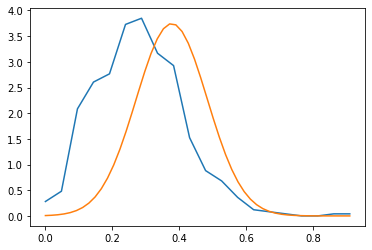

In [5]:
he=np.histogram(errors, bins=20, density=True)
m,v = errors.mean(), errors.var()
xe=np.linspace(0, he[1][-1], he[0].size)
xe2=np.linspace(0, he[1][-1])
plt.plot(xe, he[0])

plt.plot(xe2, np.exp(-(xe2-m)**2/(2*v))/np.sqrt(2*np.pi*v))
plt.show()

In [6]:
X = [[-1*np.ones(17) for i in range(len(edgelist[snap]))] for snap in multis]
t0= tm.time()

cnt=1
for snap in multis:
    P= dict()
    for i in range(N):
        clear_output(wait=True)
        print(cnt,"/",N*len(multis))
        cnt+=1

        avg = 0
        if len(G[snap][i]) == 0: continue
        for j in G[snap][i]:
            e_idx = edgelist[snap].index({i,j}) 
            if i<j:
                X[snap][e_idx][0], p1, c1 = cycle(i, j, "s", snap)                                   #finds left ring
                r2, p2, c2 = cycle(i, j, "d", snap)                                            #finds right ring
                
                X[snap][e_idx][1]=r2 if p1 != p2 else 0.
                
                X[snap][e_idx][13:17]=getdeformation(i, j, G[snap][i], G[snap][j])
#                 print(X[snap][e_idx][0], X[snap][e_idx][1])
                if X[snap][e_idx][0]*X[snap][e_idx][1] != 0:                   #finds the extra ones only if the prev exist
#                     Di = [max(-1, next(v for v in p1 if v in G[snap][i] and v!=j)), max(-1, next(v for v in p2 if v in G[snap][i] and v!=j))] #NN of i in the loop
#                     Dj = [max(-1, next(v for v in p1 if v in G[snap][j] and v!=i)), max(-1, next(v for v in p2 if v in G[snap][j] and v!=i))] #NN of j in the loop

                    Di = next(v for v in p1 if v in G[snap][i]) #NN of i in the loop
                    Dj = next(v for v in p1 if v in G[snap][j]) #NN of j in the loop


#                     X[snap][e_idx][12:14]=getdeformation(i, j, Di, snap)
#                     X[snap][e_idx][14:16]=getdeformation(j, i, Dj, snap)
    
                    if Di != -1: #exists a N in p1 from which to start the extra loop
                        direct = "s" if i<Di else "d"
                        r3, p3 = cycle(i, Di, direct, snap)[:-1]
                        X[snap][e_idx][2] = r3 if (p3 !=p1 and p3 !=p2) else 0
                    else: X[snap][e_idx][2]=0

                    if Dj != -1:
                        direct = "d" if j<Dj else "s"
                        r4, p4 = cycle(j, Dj, direct, snap)[:-1]
                        X[snap][e_idx][3] = r4 if (p4 !=p1 and p4 !=p2) else 0
                    else: X[snap][e_idx][3]=0
                else:
                    X[snap][e_idx][2:4] = np.zeros(2)

                X[snap][e_idx][4:6] = np.array([len(G[snap][i]), len(G[snap][j])])
                X[snap][e_idx][8:11] = rneighbors(i,j, snap=snap)
                X[snap][e_idx][11:13] = [c1,c2]
            avg += len(G[snap][j])

        avg /= len(G[snap][i])                                                             #finds 3

        for j in G[snap][i]:
            idx= 7 if i>j else 6
            X[snap][edgelist[snap].index({i,j})][idx] = avg                                      #finds 4
        
print(tm.time()-t0)

12100 / 12100
71.05154633522034


In [7]:
X0=np.array(X[0])
y0=np.array(y[0])
for snap in range(1,len(multis)):
    X0=np.append(X0, X[snap], 0)
    y0=np.append(y0, y[snap], 0)

In [8]:
keep=[0,1,2,3,11,12,13,14,15,16]
# X = X0[:,keep]; y=y0
X, y = X0, y0

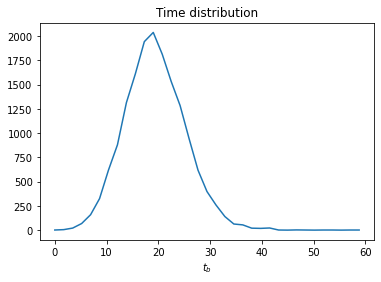

In [9]:
H=np.histogram(y, bins=35)
plt.plot(np.linspace(0, H[1][-1], H[0].size), H[0])
plt.title("Time distribution")
plt.xlabel("$t_b$")
plt.show()

In [10]:
def cleanx(x):
    return 16 if (x==0 or x>15) else x

X[:, 0:4]=[[cleanx(i) for i in x] for x in X[:, 0:4]]

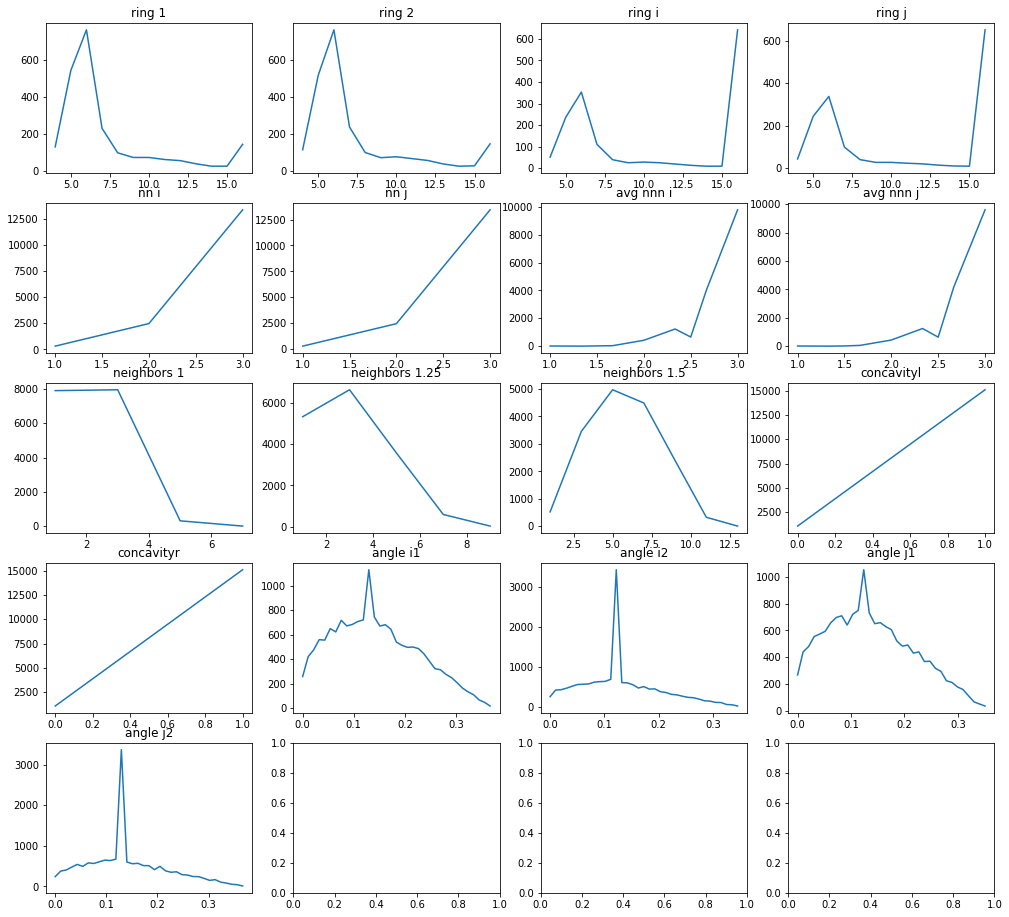

In [11]:
labels=["ring 1", "ring 2", "ring i", "ring j", "nn i", "nn j", "avg nnn i", "avg nnn j", "neighbors 1", "neighbors 1.25", "neighbors 1.5", "concavityl", "concavityr", "angle i1", "angle i2", "angle j1", "angle j2", "TIME"]

fig, ax = plt.subplots(5,4, figsize=(17,16))
for s in range(X.shape[1]):
    if s<13:
        l,occ = np.unique(X[:,s], return_counts=True)
    else:
        H=np.histogram(X[:,s], bins=35)
        l, occ = np.linspace(0, H[1][-1], H[0].size), H[0]
    if s<4: occ[1:]=occ[1:]/l[1:]
        
    ax[s//4][s%4].plot(l, occ)
    ax[s//4][s%4].set_title(labels[s])
    
plt.show()

# Learning parameters

In [12]:
#Importing the relevant parts of pytorch
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import pandas as pd
import seaborn as sb
torchX=torch.from_numpy(X).float()
torchy=torch.from_numpy(y/y.mean()).float().unsqueeze(1)

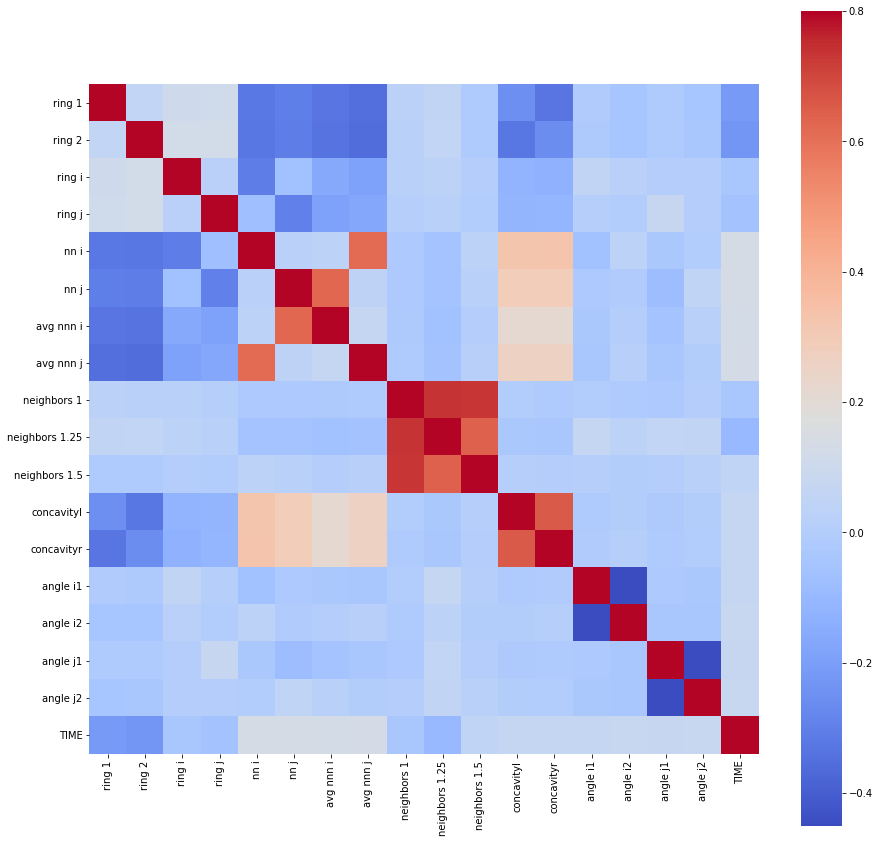

In [13]:
DF=np.hstack((X,np.atleast_2d(y).T))
DF=pd.DataFrame(DF)
DF.columns = labels
#DF.index=[str(e) for e in edgelist]

C_mat = DF.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True, cmap="coolwarm")
plt.show()

In [14]:
def test_train_split(X, y, test_fraction, shuffle=True):
    d_size = len(X)
    indices = list(range(d_size))
    split = int(np.floor(test_fraction*d_size))
    if shuffle:
        np.random.seed(1)
        np.random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]
    return (X[train_indices], y[train_indices], X[test_indices], y[test_indices], test_indices)

def accuracy(model, X, y, pct_close):
    n=len(y)
    n_correct = torch.sum(torch.abs(model(X)-y)<torch.abs(pct_close*y))
    return n_correct.item()*100./n

def rcorr(x,y):
    mx, my = x.mean(), y.mean()
    return np.sum((x-mx)*(y-my))/np.sqrt(np.sum((x-mx)**2)*np.sum((y-my)**2))

#Set a fixed seed, since we're testing things
torch.manual_seed(1)    # reproducible

# X_train, y_train, X_test, y_test, tests=test_train_split(torchX,torchy, .2)

In [15]:
def makelist(i):
    A = np.zeros(10)
    if i < 10: A[i] = 1
    if i > 16: A[0] = 1
    return A

Xmeans=X.mean(0)

def convert(l):
    K = []
    for j in l[0:6]: 
        K.append(makelist(j.astype(int)))
    K.append(l)
#    for j in l[8:]: 
#        K.append(makelist(j.astype(int)))
    return np.concatenate(K)
print(list(X[0]))
print(convert(list(X[0])))

XX=np.array([convert(i) for i in X])

torchXX=torch.from_numpy(XX).float()

X_train, y_train, X_test, y_test, tests=test_train_split(torchXX,torchy, .2)

[6.0, 6.0, 16.0, 16.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 5.0, 1.0, 1.0, -0.6278313324101307, -0.6294015753560047, -0.3243953768330785, -0.10996641023989995]
[ 0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  6.          6.         16.         16.          3.          3.
  3.          3.          1.          1.          5.          1.
  1.         -0.62783133 -0.62940158 -0.32439538 -0.10996641]


### Mini-batch

In [19]:
#One way to define a network
nx=XX.shape[1]

netwidth = 20
net = torch.nn.Sequential(
        torch.nn.Linear(nx, netwidth),
        torch.nn.ELU(),
        torch.nn.Linear(netwidth, netwidth),
        torch.nn.ELU(),
        torch.nn.Linear(netwidth, netwidth),
        torch.nn.ELU(), 
        torch.nn.Linear(netwidth, netwidth), 
        torch.nn.ELU(), 
        torch.nn.Linear(netwidth, netwidth),
        torch.nn.ELU(),
        torch.nn.Linear(netwidth, 1),
    )

bestnet=net

device = 'cpu'
net = net.to(device)
dataset = Data.TensorDataset(X_train.to(device), y_train.to(device))

BATCH_SIZE = 1000

loader = Data.DataLoader(
    dataset=dataset, 
     batch_size=BATCH_SIZE, shuffle=True )

#Optimizer: Adam
optimizer = torch.optim.Adam(net.parameters(), lr=0.0025, weight_decay=0.00001) 

#Stochastic Gradient Descent is another option
#optimizer =  torch.optim.SGD(net.parameters(), lr = 0.05, momentum=0.9, weight_decay=1e-5)

loss_func = torch.nn.MSELoss()  # this is our loss function: mean squared error
LOSS=[]
CORR=[]
bestcorr = 0

In [20]:
# train the network

showplot=0
bestcorr=0

for t in range(600):
    for step, (batch_x, batch_y) in enumerate(loader):
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        prediction = net(b_x)     # input x and predict based on x

        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)

        #Print loss each cycle to keep track, after clearing the previous print statements

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    netcpu = net.cpu()
    pred_test = netcpu(X_test)
    net = net.to(device)
    newcorr = rcorr(pred_test.data.numpy(), y_test.data.numpy())
    
    if newcorr>bestcorr: 
        bestnet.load_state_dict(net.state_dict())
        bestit=(t+step, newcorr)
        bestcorr=newcorr
        
    LOSS.append(loss_func(pred_test,y_test))
    CORR.append(newcorr)
    # plot current status: prediction versus real value

    clear_output(wait=True)
    plt.pause(0.05)
    
    if showplot:
        # plot current status: prediction versus real value
        tt = np.linspace(min(y_train), max(y_train), 5)

        fig, ax = plt.subplots(figsize=(12,7))
        ptitle='%d) %f  %f '%(t, loss.data.numpy(), rcorr(net(X_test).data.numpy(), y_test.data.numpy()))

        ax.set_title(ptitle, fontsize=25)
        ax.set_xlabel('prediction', fontsize=24)
        ax.set_ylabel('real value', fontsize=24)

    #     par="d= "+str(d/100)+"\n"+"e= "+str(e/100)
    #     tx,ty= (np.min(prediction.data.numpy())*.9, np.max(prediction.data.numpy())*.9)
    #     plt.text(tx, ty, par, fontsize=20)
        plt.scatter(net(X_train).data.numpy(), y_train.data.numpy(), color = "orange")

        # Dashed line is the ideal result
        plt.plot(tt,tt,'r--')
    else:
        print('%d) %.5f  %.5f %.5f '%(t, loss.item(), loss_func(pred_test,y_test).item(),newcorr))

net.load_state_dict(bestnet.state_dict())
        

599) 0.02398  0.02807 0.60555 


<All keys matched successfully>

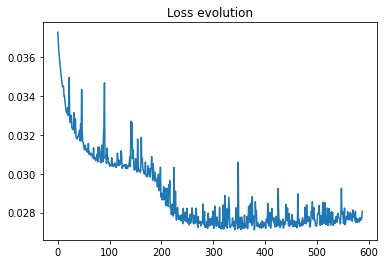

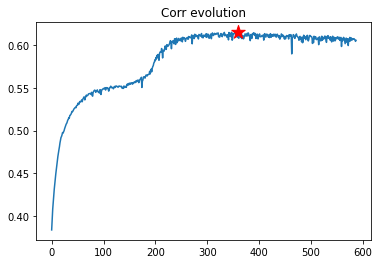

In [21]:
skip=12
plt.plot(LOSS[skip:])
plt.title("Loss evolution")
plt.show()
plt.plot(CORR[skip:], zorder=1)
plt.title("Corr evolution")
plt.scatter(bestit[0]-12, bestit[1], s=200, c="r", marker="*", zorder=2)
plt.show()

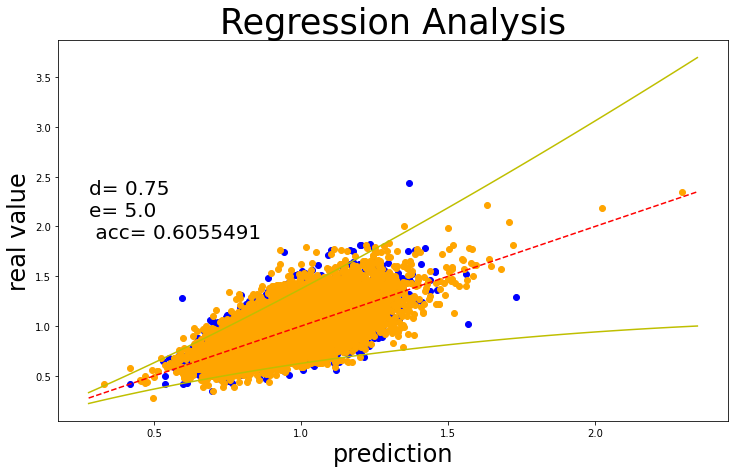

In [23]:
# plot current status: prediction versus real value
acc = rcorr(net(X_test).data.numpy(), y_test.data.numpy())
tt = np.linspace(min(y_train), max(y_train))
SE = (tt*y.mean())**(3/2)/np.sqrt(time)

fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Regression Analysis', fontsize=35)
ax.set_xlabel('prediction', fontsize=24)
ax.set_ylabel('real value', fontsize=24)

par="d= "+str(d/100)+"\n"+"e= "+str(e/100)+"\n acc= "+str(acc)
tx,ty= (tt[0], .8*tt[-1])

plt.scatter(net(X_test).data.numpy(), y_test.data.numpy(), color = "blue")
plt.scatter(net(X_train).data.numpy(), y_train.data.numpy(), color = "orange")
# Dashed line is the ideal result
plt.plot(tt,tt,'r--')
plt.plot(tt,tt+SE,'y')
plt.plot(tt,tt-SE,'y')

plt.text(tx, ty, par, fontsize=20)
plt.show()

In [ ]:
net.to('cpu')



err_pred = normalize(net(torchXX))
net_err = (net(torchXX)-torchy)**2
#net_err = ((net_err - net_err.mean(0))/net_err.std(0)+1)/2
net_err = normalize(net_err)
net_err = np.squeeze(net_err.data.numpy())
err_pred = np.squeeze(err_pred.data.numpy())

In [ ]:
framelengths=[len(E) for E in events]
framestarts=np.insert(np.cumsum(framelengths),0,0)

In [ ]:
def plotbonds(EEE, CC, tt, title):
    plt.figure(figsize = (8,8))
    plt.axis("off")
    plt.title(title, fontsize=24)
    δ = .6
    ttt = (tt - 0.5)/2 + 0.5

    for ev in range(EEE[:,2].size):   #Bonds
        r1 = np.array(CC[int(EEE[ev,0])][:])
        r2 = np.array(CC[int(EEE[ev,1])][:])
        dr = [rescale((r2 - r1)[0], xsize), rescale((r2-r1)[1], ysize)]
        line='-' 

        col = pl.cm.coolwarm(ttt[ev])
        plt.plot([r1[0], r1[0]+δ*dr[0]/np.linalg.norm(dr)], [r1[1], r1[1]+δ*dr[1]/np.linalg.norm(dr)], color=col, linewidth=5, zorder=1)
        plt.plot([r2[0], r2[0]-δ*dr[0]/np.linalg.norm(dr)], [r2[1], r2[1]-δ*dr[1]/np.linalg.norm(dr)], color=col, linewidth=5, zorder=1)

    plt.show()

In [ ]:
snap =2   


CC=C[snap];
EE=np.array(events[snap])
EEE=np.array([np.array(i) for i in EE])

yyy = time/EEE[:,2]
t_b = (((yyy-np.mean(yyy))/np.std(yyy))+1)/2 

t_p = err_pred[framestarts[snap]:framestarts[snap+1]]

plotbonds(EEE,CC,t_b, "Real value")
plotbonds(EEE,CC,t_p, "Predicted Value")


In [ ]:
# Square error
se=(t_p-t_b)**2 + 0.5
plotbonds(EEE,CC,se, "Squared Error")

## Clustering tests

In [ ]:
def vmap(self, cmap,cmin, cmax):
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    self.imshow([colors], extent=[cmin, cmax, 0, .1])
    self.get_yaxis().set_visible(False)

In [ ]:
fig,ax = plt.subplots(figsize=(10, 10))
cbar, cax = plt.subplots(figsize=(6,10))
ax.axis("off")
#ax = plt.axes()
δ = .6
s=0
pred=net(torchXX[0:len(events[0])])
mu, std=pred.mean().item(), pred.std().item()
# pred=((pred-mu)/std+1)/2
pred=(pred-mu)/std
# cmap = col.ListedColormap(['limegreen','yellow','red'])
cmap=pl.cm.brg

for ev in range(len(events[s])):   #Bonds
    lab = cmap(pred[ev].item(), )
    r1 = np.array(C[s][int(events[s][ev][0])][:])
    r2 = np.array(C[s][int(events[s][ev][1])][:])
    dr = [rescale((r2 - r1)[0], xsize), rescale((r2-r1)[1], ysize)]
    ax.plot([r1[0], r1[0]+δ*dr[0]/np.linalg.norm(dr)], [r1[1], r1[1]+δ*dr[1]/np.linalg.norm(dr)], color=lab, linewidth=5, zorder=1)
    ax.plot([r2[0], r2[0]-δ*dr[0]/np.linalg.norm(dr)], [r2[1], r2[1]-δ*dr[1]/np.linalg.norm(dr)], color=lab, linewidth=5, zorder=1)
    
# ax[0].scatter(C[s][:,0], C[s][:,1], s=100, zorder=2)   #Particles

vmap(cax,cmap, min(pred.detach().numpy()), max(pred.detach().numpy()))

plt.show()

### Full batch Neural Network

In [ ]:
#One way to define a network
nx=XX.shape[1]
net = torch.nn.Sequential(
        torch.nn.Linear(nx, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 1),
    )

#Optimizer: Adam
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) 
#Stochastic Gradient Descent is another option
# optimizer =  torch.optim.SGD(net.parameters(), lr = 0.05, momentum=0.9, weight_decay=1e-5)

loss_func = torch.nn.MSELoss()  # this is our loss function: mean squared error
LOSS=[]
# train the network

In [ ]:
# train the network
# You can run this cell multiple times, or just change the number of steps.
# I get decent results after ~10000 steps.
# Given the current size of the dataset, we may be overfitting...
showplot=0
for t in range(700):
    
    prediction = net(X_train)     # input x and predict based on x

    loss = loss_func(prediction, y_train)     # must be (1. nn output, 2. target)

    #Print loss each cycle to keep track, after clearing the previous print statements

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    pred_test = net(X_test)
    LOSS.append(loss_func(pred_test,y_test))
    CORR.append(rcorr(net(X_test).data.numpy(), y_test.data.numpy()))
    
    clear_output(wait=True)
    plt.pause(0.05)
    
    if showplot:
        # plot current status: prediction versus real value
        tt = np.arange(min(y_train), max(y_train), 0.2)

        fig, ax = plt.subplots(figsize=(12,7))
        ptitle='%d) %f  %f '%(t, loss.data.numpy(), rcorr(net(X_test).data.numpy(), y_test.data.numpy()))

        ax.set_title(ptitle, fontsize=25)
        ax.set_xlabel('prediction', fontsize=24)
        ax.set_ylabel('real value', fontsize=24)

    #     par="d= "+str(d/100)+"\n"+"e= "+str(e/100)
        tx,ty= (np.min(prediction.data.numpy())*.9, np.max(prediction.data.numpy())*.9)
    #     plt.text(tx, ty, par, fontsize=20)

        plt.scatter(net(X_test).data.numpy(), y_test.data.numpy(), color = "green")
        plt.scatter(net(X_train).data.numpy(), y_train.data.numpy(), color = "orange")

        # Dashed line is the ideal result
        plt.plot(tt,tt,'r--')
    else:
        ptitle='%d) %f  %f '%(t, loss.data.numpy(), rcorr(net(X_test).data.numpy(), y_test.data.numpy()))
        print(ptitle)

    
    #print(t, "/", epoch,"   ",loss.data.numpy(), rcorr(net(X_test).data.numpy(), y_test.data.numpy()))
        

In [ ]:
# plot current status: prediction versus real value
acc = rcorr(net(X_test).data.numpy(), y_test.data.numpy())
tt = np.linspace(min(y_train), max(y_train))
SE = 

fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Regression Analysis', fontsize=35)
ax.set_xlabel('prediction', fontsize=24)
ax.set_ylabel('real value', fontsize=24)

par="d= "+str(d/100)+"\n"+"e= "+str(e/100)+"\n acc= "+str(acc)
tx,ty= (tt[0], .8*tt[-1])

plt.scatter(net(X_test).data.numpy(), y_test.data.numpy(), color = "green")
plt.scatter(net(X_train).data.numpy(), y_train.data.numpy(), color = "orange")
# Dashed line is the ideal result
plt.plot(tt,tt,'r--')
plt.text(tx, ty, par, fontsize=20)
plt.show()

# linear corr coefficient (no free parameters--> more standard)
tr_acc=rcorr(net(X_train).data.numpy(), y_train.data.numpy())
print("(%.2f) Correlation of %0.2f %%" % (tr_acc, acc*100))
best=40
best= max(best, acc*100)
print("Best value: %.2f" % (best))

In [ ]:
fig, ax= plt.subplots(figsize=(12,8))
DH=np.histogram(np.abs(net(X_test).data.numpy()-y_test.data.numpy())/max(net(X_test).data.numpy()), bins=35)
plt.plot(np.linspace(0, DH[1][-1], DH[0].size), DH[0])
ax.set_title("Distance of the prediction", size=25)
ax.set_xlabel("$\Delta t_b$", size=20)
ax.set_ylabel("test data", size=20)
plt.show()

# END